# Access Computation

This tutorial demonstrates how to compute access.

## Setup

In [1]:
import sys

! {sys.executable} -m pip install --quiet LibraryCorePy
! {sys.executable} -m pip install --quiet LibraryMathematicsPy
! {sys.executable} -m pip install --quiet LibraryPhysicsPy
! {sys.executable} -m pip install --quiet LibraryAstrodynamicsPy

In [2]:
import numpy as np
import pandas as pd

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

In [3]:
import Library.Core as Core
import Library.Mathematics as Mathematics
import Library.Physics as Physics
import Library.Astrodynamics as Astrodynamics

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

to-Python converter for library::physics::time::DateTime already registered; second conversion method ignored.

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

to-Python converter for library::math::obj::IntervalBase::Type already registered; second conversion method ignored.



In [4]:
Length = Physics.Units.Length
Angle = Physics.Units.Angle
Scale = Physics.Time.Scale
Instant = Physics.Time.Instant
Duration = Physics.Time.Duration
Interval = Physics.Time.Interval
DateTime = Physics.Time.DateTime
LLA = Physics.Coordinate.Spherical.LLA
AER = Physics.Coordinate.Spherical.AER
Position = Physics.Coordinate.Position
Frame = Physics.Coordinate.Frame
Environment = Physics.Environment
Earth = Physics.Environment.Objects.CelestialBodies.Earth

Trajectory = Astrodynamics.Trajectory
Orbit = Astrodynamics.Trajectory.Orbit
Access = Astrodynamics.Access

---

## Access

An access represents an object-to-object visibility period.

In this example, let's compute accesses between a fixed position on the ground and a satellite in LEO.

## Environment

Let's setup an environment (which describes where planets are, etc...):

In [5]:
environment = Environment.Default() ;

### Origin

Let's define a fixed ground position, using its geographic coordinates:

In [233]:
# Center

# latitude = Angle.Degrees(0.0)
# longitude = Angle.Degrees(0.0)
# altitude = Length.Meters(10.0)

# SvalSat

# latitude = Angle.Degrees(78.229772)
# longitude = Angle.Degrees(15.407786)
# altitude = Length.Meters(10.0)

# Test

latitude = Angle.Degrees(-40.0)
longitude = Angle.Degrees(-70.0)
altitude = Length.Meters(10.0)

In [234]:
from_lla = LLA(latitude, longitude, altitude)

In [235]:
from_position = Position.Meters(from_lla.toCartesian(Earth.EquatorialRadius, Earth.Flattening), Frame.ITRF())

And derive a trajectory, fixed at that position:

In [236]:
from_trajectory = Trajectory.Position(from_position)

### Target

Let's define the orbit of a satellite in LEO. In this example, we're modeling the orbit using SGP4.

In [237]:
a = Earth.EquatorialRadius + Length.Kilometers(600.0)
e = 0.000
# i = Angle.Degrees(97.5034)
i = Angle.Degrees(97.8893)
raan = Angle.Degrees(100.372)
aop = Angle.Degrees(0.0)
nu = Angle.Degrees(0.0201851)

coe = Orbit.Models.Kepler.COE(a, e, i, raan, aop, nu)

In [238]:
epoch = Instant.DateTime(DateTime(2018, 1, 1, 0, 0, 0), Scale.UTC)
earth = environment.accessCelestialObjectWithName("Earth")

keplerian_model = Orbit.Models.Kepler(coe, epoch, earth, Orbit.Models.Kepler.PerturbationType.J2)

First, we need a **Two-Line Element** (TLE) set:

In [239]:
# tle = Orbit.Models.SGP4.TLE("1 25544U 98067A   18231.17878740  .00000187  00000-0  10196-4 0  9994",
#                             "2 25544  51.6447  64.7824 0005971  73.1467  36.4366 15.53848234128316")
# tle = Orbit.Models.SGP4.TLE("1 39419U 13066D   18248.44969859 -.00000394  00000-0 -31796-4 0  9997",
#                             "2 39419  97.6313 314.6863 0012643 218.7350 141.2966 14.93878994260975")

tle = Orbit.Models.SGP4.TLE("ISS (ZARYA)",
                            "1 25544U 98067A   18268.86272795  .00002184  00000-0  40781-4 0  9990",
                            "2 25544  51.6405 237.0010 0003980 205.4375 242.3358 15.53733046134172")

To setup a **SGP4** orbital model:

In [240]:
sgp4_model = Orbit.Models.SGP4(tle)

In [241]:
# orbital_model = keplerian_model
orbital_model = sgp4_model

We then obtain the satellite orbit (which is a trajectory):

In [242]:
environment = Environment.Default()
satellite_orbit = Orbit(orbital_model, environment.accessCelestialObjectWithName("Earth"))

### Access

Now that the origin and the target trajectories is well defined, we can compute the access.

Let's first define an **interval of interest**:

In [243]:
start_instant = Instant.DateTime(DateTime.Parse("2018-01-01 00:00:00"), Scale.UTC) ;
end_instant = Instant.DateTime(DateTime.Parse("2018-01-10 00:00:00"), Scale.UTC) ;

interval = Interval.Closed(start_instant, end_instant) ;

In [244]:
environment = Physics.Environment.Default() ;

Then, using an **Access Generator**, we can compute the accesses within the intervals of interest:

In [245]:
access_generator = Access.Generator(environment) ;

accesses = access_generator.computeAccesses(interval, from_trajectory, satellite_orbit) ;

In [246]:
# states = satellite_orbit.getStatesAt(access.getInterval().generateGrid(Duration.Minutes(1.0)))

And format the output using a dataframe:

In [247]:
accesses_df = pd.DataFrame([[str(access.getType()), repr(access.getAcquisitionOfSignal()), repr(access.getTimeOfClosestApproach()), repr(access.getLossOfSignal()), float(access.getDuration().inSeconds())] for access in accesses], columns=['Type', 'AOS', 'TCA', 'LOS', 'Duration'])

In [248]:
accesses_df

,Type,AOS,TCA,LOS,Duration
0,Complete,2018-01-01 00:18:17.697.156.070 [UTC],2018-01-01 00:22:53.497.750.364 [UTC],2018-01-01 00:27:29.436.445.532 [UTC],551.739289
1,Complete,2018-01-01 01:55:39.150.745.866 [UTC],2018-01-01 02:00:35.711.234.012 [UTC],2018-01-01 02:05:29.858.056.603 [UTC],590.707311
2,Complete,2018-01-01 03:32:12.157.332.300 [UTC],2018-01-01 03:37:41.976.868.711 [UTC],2018-01-01 03:43:07.631.351.350 [UTC],655.474019
3,Complete,2018-01-01 05:09:17.177.879.509 [UTC],2018-01-01 05:13:54.893.248.477 [UTC],2018-01-01 05:18:27.727.380.393 [UTC],550.549501
4,Complete,2018-01-01 18:41:34.249.314.664 [UTC],2018-01-01 18:42:20.906.922.422 [UTC],2018-01-01 18:43:13.024.453.816 [UTC],98.775139
5,Complete,2018-01-01 20:12:51.193.073.985 [UTC],2018-01-01 20:18:02.725.464.903 [UTC],2018-01-01 20:23:18.420.799.075 [UTC],627.227725
6,Complete,2018-01-01 21:49:17.384.174.463 [UTC],2018-01-01 21:54:36.185.242.735 [UTC],2018-01-01 21:59:58.050.011.692 [UTC],640.665837
7,Complete,2018-01-01 23:27:18.650.360.403 [UTC],2018-01-01 23:31:59.992.615.782 [UTC],2018-01-01 23:36:42.171.510.456 [UTC],563.521150
8,Complete,2018-01-02 01:04:59.318.175.315 [UTC],2018-01-02 01:09:44.897.400.938 [UTC],2018-01-02 01:14:28.682.983.515 [UTC],569.364808
9,Complete,2018-01-02 02:41:39.691.648.183 [UTC],2018-01-02 02:47:04.394.471.250 [UTC],2018-01-02 02:52:25.242.659.745 [UTC],645.551012


In [249]:
len(accesses_df)

65

In [250]:
accesses_df['Duration'].mean() / 60

9.452275982500767

### Output

Let's calculate the geographic coordinate of the satellite, during access:

In [251]:
def compute_time_lla_aer_state (state):
    
    lla = LLA.Cartesian(state.getPosition().inFrame(Frame.ITRF(), state.getInstant()).getCoordinates(), Earth.EquatorialRadius, Earth.Flattening)
    
    aer = AER.FromPositionToPosition(from_position, state.getPosition().inFrame(Frame.ITRF(), state.getInstant()))

    return [state.getInstant(), float(lla.getLatitude().inDegrees()), float(lla.getLongitude().inDegrees()), float(lla.getAltitude().inMeters()), float(aer.getAzimuth().inDegrees()), float(aer.getElevation().inDegrees()), float(aer.getRange().inMeters())]

def compute_access_geometry (access):

    return [compute_time_lla_aer_state(state) for state in satellite_orbit.getStatesAt(access.getInterval().generateGrid(Duration.Minutes(1.0)))]

In [252]:
access_geometry_dfs = [pd.DataFrame(compute_access_geometry(access), columns=['Time', 'Latitude', 'Longitude', 'Altitude', 'Azimuth', 'Elevation', 'Range']) for access in accesses] ;

In [253]:
access_geometry_dfs[0].head()

,Time,Latitude,Longitude,Altitude,Azimuth,Elevation,Range
0,-- Instant -----------------------------------...,-47.154917,-96.576450,423703.382750,180.131720,21.903066,2.375522e+06
1,-- Instant -----------------------------------...,-48.642399,-91.504192,424183.933371,176.915252,29.249385,2.056389e+06
2,-- Instant -----------------------------------...,-49.869927,-86.139433,424565.018364,171.128392,38.272531,1.776066e+06
3,-- Instant -----------------------------------...,-50.812659,-80.518225,424839.677244,160.053040,48.807382,1.557073e+06
4,-- Instant -----------------------------------...,-51.449397,-74.696311,425002.673407,137.821257,58.566755,1.428940e+06


And plot the geometries onto a map:

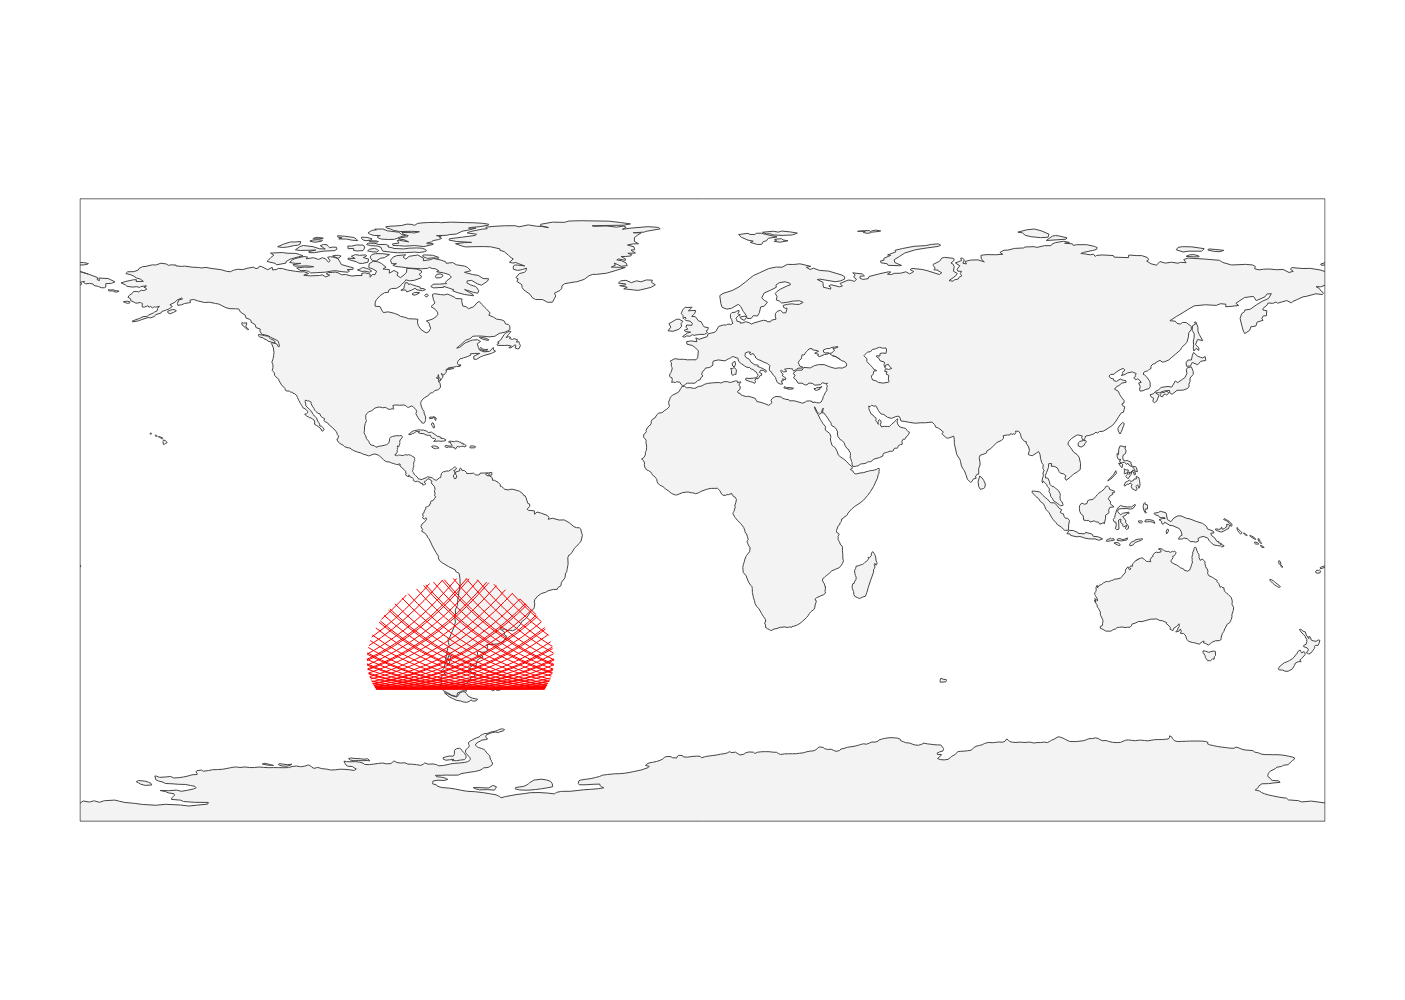

In [254]:
access_paths = []

for access_geometry_df in access_geometry_dfs:
    
    access_paths.append(
        dict(
            type = 'scattergeo',
            lon = access_geometry_df['Longitude'],
            lat = access_geometry_df['Latitude'],
            mode = 'lines',
            line = dict(
                width = 1,
                color = 'red',
            )
        )
    )
    
layout = dict(
        title = None,
        showlegend = False,
        height= 1000,
        geo = dict(
            showland = True,
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)',
        ),
    )
    
fig = dict(data=access_paths, layout=layout)
iplot(fig)